In [1]:
import os
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical #相当于one-hot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import copy
import tensorflow as tf
import numpy as np

# 定义各个不同手势对应的标签
gesture = ['大拇指向上','大拇指向下','向右','向左','停止']
position_dic = {0:'大拇指向上',1:'大拇指向下',2:'向右',3:'向左',4:'停止'}

# 收集数据相关信息
def get_info(file_path_list,tar_sensor = 'acc_raw.mat', data_dir = 'dataset'):
    '''
    查看每组数据序列的最短长度, 为归一化作准备
    记录每组传感器数据的最大/最小值, 将数据归一化至0-1之间
    tar_sensor: acc_raw.mat, EMGs_raw.mat, gyro_raw.mat
    '''
    min_len = 1e5
    acc_dic ={'max_x':-1e5,'min_x':1e5,'max_y':-1e5,'min_y':1e5,'max_z':-1e5,'min_z':1e5}
    gyro_dic ={'max_x':-1e5,'min_x':1e5,'max_y':-1e5,'min_y':1e5,'max_z':-1e5,'min_z':1e5}
    
    cur_path = os.getcwd()
    data = []
    label = []
    file_path_list = [data_dir+'/'+i for i in file_path_list]
    for file_path in file_path_list:
        os.chdir(file_path)
        dirs = [i for i in os.listdir() if os.path.isdir(i) and i[0] != '.']
        dirs.sort()
        for d in dirs:
            # acc是加速度计, gyro是陀螺仪
            acc  = loadmat(f'{d}/acc_raw.mat')['accel_data']
            if acc_dic['max_x'] < max(acc[:,0]):
                acc_dic['max_x'] = max(acc[:,0])
            if acc_dic['min_x'] > min(acc[:,0]):
                acc_dic['min_x'] = min(acc[:,0])
                
            if acc_dic['max_y'] < max(acc[:,1]):
                acc_dic['max_y'] = max(acc[:,1])
            if acc_dic['min_y'] > min(acc[:,1]):
                acc_dic['min_y'] = min(acc[:,1])
            if acc_dic['max_z'] < max(acc[:,2]):
                acc_dic['max_z'] = max(acc[:,2])
            if acc_dic['min_z'] > min(acc[:,2]):
                acc_dic['min_z'] = min(acc[:,2])
 
            emgs = loadmat(f'{d}/EMGs_raw.mat')['emg_data']
            gyro = loadmat(f'{d}/gyro_raw.mat')['gryo_data']
            if gyro_dic['max_x'] < max(gyro[:,0]):
                gyro_dic['max_x'] = max(gyro[:,0])
            if gyro_dic['min_x'] > min(gyro[:,0]):
                gyro_dic['min_x'] = min(gyro[:,0])
            if gyro_dic['max_y'] < max(gyro[:,1]):
                gyro_dic['max_y'] = max(gyro[:,1])
            if gyro_dic['min_y'] > min(gyro[:,1]):
                gyro_dic['min_y'] = min(gyro[:,1])
            if gyro_dic['max_z'] < max(gyro[:,2]):
                gyro_dic['max_z'] = max(gyro[:,2])
            if gyro_dic['min_z'] > min(gyro[:,2]):
                gyro_dic['min_z'] = min(gyro[:,2])
        
            min_len = min(min_len, acc.shape[0], emgs.shape[0], gyro.shape[0])
        os.chdir(cur_path)
        
    return min_len, acc_dic, gyro_dic

In [2]:
min_len, acc_dic, gyro_dic = get_info(gesture)

In [3]:
# 利用滑动窗口法对采集数据进行平滑
def smoth_data(data, window = 5):
    l = len(list(data))
    data_smoth = copy.deepcopy(data)
    for i in range(int(window/2), l-int(window/2)):
        data_smoth[i] = np.mean(data[i-int(window/2):i+int(window/2)])
    
    return data_smoth

def smoth_data_matrix(data, window = 5):
    row, col = data.shape
    data_smoth = copy.deepcopy(data)
    for i in range(col):
        for j in range(int(window/2), row-int(window/2)):
            data_smoth[j,i] = np.mean(data[j-int(window/2):j+int(window/2),i])
    
    return data_smoth

show_file = 'dataset/大拇指向上/1/EMGs_raw.mat'
data = loadmat(show_file)['emg_data']

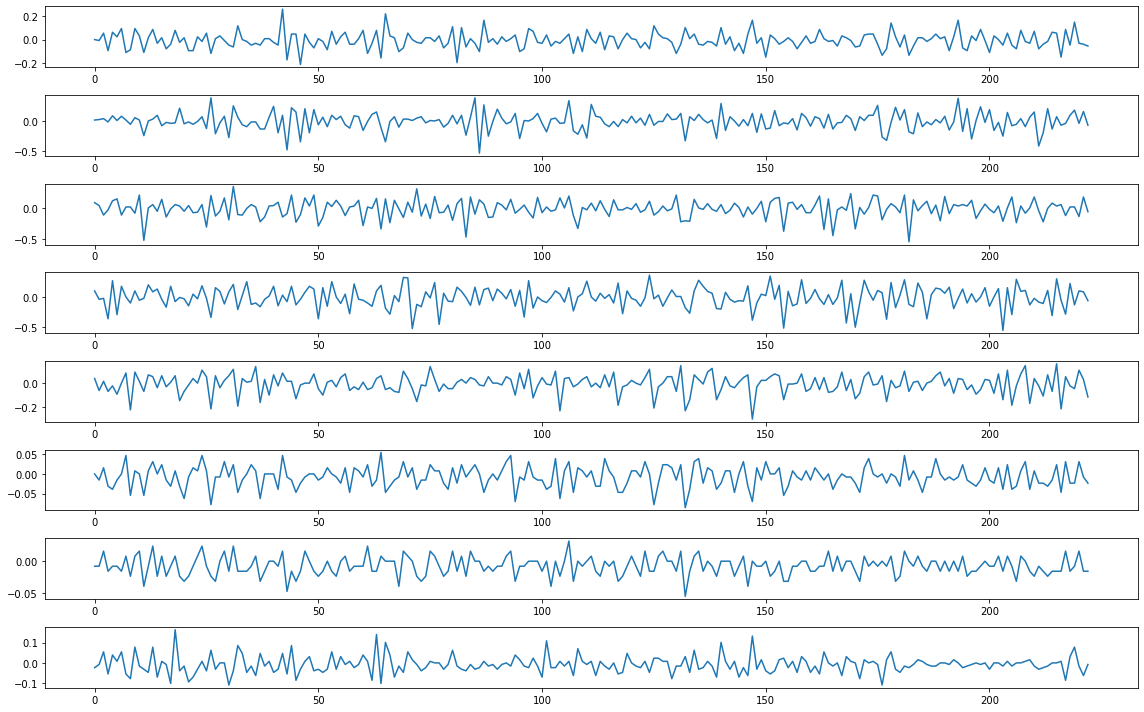

In [4]:
# 未经过平滑处理的图
plt.figure(figsize=(16, 10))
plt.subplot(data.shape[1], 1, 1)
for i in range(data.shape[1]):
    plt.subplot(data.shape[1],1, i + 1)
    plt.plot(data[:,i])
    plt.tight_layout()

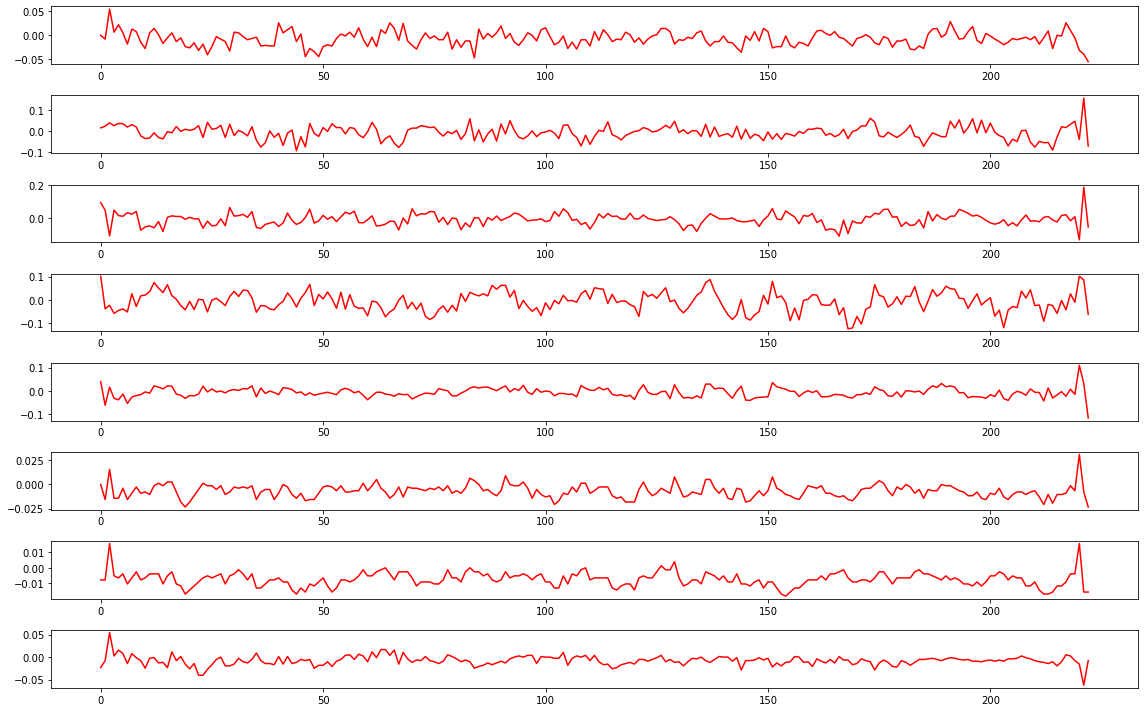

In [5]:
# 经过平滑处理的图
plt.figure(figsize=(16, 10))
plt.subplot(data.shape[1], 1, 1)
for i in range(data.shape[1]):
    plt.subplot(data.shape[1],1, i + 1)
    plt.plot(smoth_data(data[:,i],7),color='r')
    plt.tight_layout()

In [13]:
# 将所有传感器数据整合成同样大小
def norm(na,min_length=min_len):
    return na[:min_length,:]

# 神经网络输入加载数据
def load_data(file_path_list, data_dir = 'dataset', class_num = 5):
    cur_path = os.getcwd()
    data = []
    label = []
    file_path_list = [data_dir+'/'+i for i in file_path_list]
    for file_path in file_path_list:
        os.chdir(file_path)
        dirs = [i for i in os.listdir() if os.path.isdir(i) and i[0] != '.']
        dirs.sort()
#         
        for d in dirs:
            # acc是加速度计, gyro是陀螺仪
            acc  = loadmat(f'{d}/acc_raw.mat')['accel_data']
            emgs = loadmat(f'{d}/EMGs_raw.mat')['emg_data']
            gyro = loadmat(f'{d}/gyro_raw.mat')['gryo_data']
#             print(acc.shape, gyro.shape, emgs.shape)
#             min_value = min((min_value, acc.shape[0], emgs.shape[0]))
#             data.append(np.hstack([norm(acc), norm(gyro),norm(emgs)]))
            data.append(np.hstack([norm(acc), norm(emgs)]))
            label.append(gesture.index(file_path.split('/')[1]))
        os.chdir(cur_path)
#     print(f'{file_path}文件夹下最小数据为{min_value}')
#     data = tf.expand_dims(data, axis=-1)
    data = np.array(data).reshape(-1, min_len, acc.shape[1]+emgs.shape[1], 1)
    label = to_categorical(np.array(label),num_classes=class_num) # 转化成5个类别的独热编码
    return data, label

# 加载数据并做0-1归一化
def load_data_norm01(file_path_list, data_dir = 'dataset', class_num = 5):
    cur_path = os.getcwd()
    data = []
    label = []
    file_path_list = [data_dir+'/'+i for i in file_path_list]
    for file_path in file_path_list:
        os.chdir(file_path)
        dirs = [i for i in os.listdir() if os.path.isdir(i) and i[0] != '.']
        dirs.sort()
#         
        for d in dirs:
            # acc是加速度计, gyro是陀螺仪
            acc  = loadmat(f'{d}/acc_raw.mat')['accel_data']
            acc[:,0] = (acc[:,0] - acc_dic['min_x'])/(acc_dic['max_x']-acc_dic['min_x'])
            acc[:,1] = (acc[:,1] - acc_dic['min_y'])/(acc_dic['max_y']-acc_dic['min_y'])
            acc[:,2] = (acc[:,2] - acc_dic['min_z'])/(acc_dic['max_z']-acc_dic['min_z'])
            emgs = loadmat(f'{d}/EMGs_raw.mat')['emg_data']
            gyro = loadmat(f'{d}/gyro_raw.mat')['gryo_data']
            gyro[:,0] = (gyro[:,0] - gyro_dic['min_x'])/(gyro_dic['max_x']-gyro_dic['min_x'])
            gyro[:,1] = (gyro[:,1] - gyro_dic['min_y'])/(gyro_dic['max_y']-gyro_dic['min_y'])
            gyro[:,2] = (gyro[:,2] - gyro_dic['min_z'])/(gyro_dic['max_z']-gyro_dic['min_z'])
            data.append(np.hstack([norm(acc), norm(gyro)]))
            label.append(gesture.index(file_path.split('/')[1]))
        os.chdir(cur_path)
    data = np.array(data).reshape(-1, min_len, acc.shape[1]+gyro.shape[1], 1)
    label = to_categorical(np.array(label),num_classes=class_num) # 转化成5个类别的独热编码
    return data, label

# 支持向量回归加载数据
def load_data_svr(file_path_list, data_dir = 'dataset', class_num = 5):
    cur_path = os.getcwd()
    data = []
    label = []
    file_path_list = [data_dir+'/'+i for i in file_path_list]
    for file_path in file_path_list:
        os.chdir(file_path)
        dirs = [i for i in os.listdir() if os.path.isdir(i) and i[0] != '.']
        dirs.sort()
        for d in dirs:
            acc  = loadmat(f'{d}/acc_raw.mat')['accel_data']
            emgs = loadmat(f'{d}/EMGs_raw.mat')['emg_data']
            gyro = loadmat(f'{d}/gyro_raw.mat')['gryo_data']
            data.append(np.hstack([norm(acc), norm(emgs)]).ravel())
            label.append(gesture.index(file_path.split('/')[1]))
        os.chdir(cur_path)

    data = np.array(data)
    label = np.array(label)
    return data, label

# softmax结果转换独热码
def softmax_to_onehot(na):
    na = na.ravel()
    ret = []
    for i in na:
        if i > 0.5:
            ret.append(1)
        else:
            ret.append(0)
    
    gesture_index = ret.index(1)
    pred_gesture = gesture[gesture_index]
    return ret, pred_gesture

# 独热码转换成0-5 label
def count_label(y_test, y_test_pred):
    y_true = []
    y_pred = []
    
    for i, j in zip(y_test, y_test_pred):
        y_true.append(list(i).index(np.max(i)))
        y_pred.append(list(j).index(np.max(j)))
    return y_true,y_pred


def plot_matrix(fact, guess, title = 'SVR'):
    fact = np.array(fact)
    guess = np.array(guess)
    accuracy = round(sum(fact==guess)/len(fact),2)*100
    classes = list(set(fact))
    classes.sort()
    confusion = confusion_matrix(guess, fact)
    plt.imshow(confusion, cmap=plt.cm.Blues)

    indices = range(len(confusion))
    plt.xticks(indices, classes)
    plt.yticks(indices, classes)
    plt.colorbar()
    plt.title(f'The accuracy of {title} is {accuracy}%')
    plt.xlabel('Predict gesture')
    plt.ylabel('True gesture')
    plt.rcParams['figure.dpi'] = 128
    for first_index in range(len(confusion)):
        for second_index in range(len(confusion[first_index])):
            plt.text(first_index, second_index, confusion[first_index][second_index])
    plt.show()

plot_matrix()

TypeError: plot_matrix() missing 2 required positional arguments: 'fact' and 'guess'

### 支持向量回归

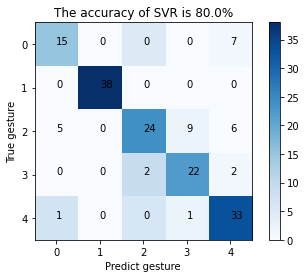

In [7]:
from sklearn.svm import SVC
X, y = load_data_svr(gesture)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3,random_state=2022)

model = SVC(kernel='rbf')
model.fit(X_train,y_train)

y_test_pred = model.predict(X_test)
plot_matrix(y_test,y_test_pred)

### ANN

In [8]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.models import Sequential
import keras.backend as K

def ANN(channel,height,width,classes = 5):
    input_shape = (height,width,channel)
    
    #顺序模型（keras中包括顺序模型和函数式API两种方式）
    model = Sequential()
    model.add(Dense(2, input_dim=4, activation='relu',name="linear1",input_shape=input_shape))
    model.add(Dense(2, activation='relu',name="linear2"))

    model.add(Flatten())
    model.add(Dense(8,activation="relu",name="fc1"))
    model.add(Dense(classes,activation="softmax",name="fc2"))
    model.compile(loss="categorical_crossentropy",
                  optimizer="Adam",metrics=["accuracy"])
    
    return model


def CNN(channel,height,width,classes = 5):
    input_shape = (height,width,channel)
    
    #顺序模型（keras中包括顺序模型和函数式API两种方式）
    model = Sequential() 
    model.add(Conv2D(2,(3,3),padding="same",activation="relu",input_shape=input_shape,name="conv1"))
    model.add(MaxPooling2D(pool_size=(2,2),padding="same",strides=(2,2),name="pool1"))
    
    model.add(Conv2D(4,(3,3),padding="same",activation="relu",name="conv2",))
    model.add(MaxPooling2D(pool_size=(2,2),padding="same",strides=(2,2),name="pool2"))
    
    model.add(Flatten())
    model.add(Dense(20,activation="relu",name="fc1"))
    model.add(Dense(classes,activation="softmax",name="fc2"))
    model.compile(loss="categorical_crossentropy",
                  optimizer="Adam",metrics=["accuracy"])
    return model

Epoch 1/10
96/96 [==============================] - 0s 763us/step - loss: 1.1985 - accuracy: 0.4856
Epoch 2/10
96/96 [==============================] - 0s 745us/step - loss: 0.6491 - accuracy: 0.8329
Epoch 3/10
96/96 [==============================] - 0s 757us/step - loss: 0.3739 - accuracy: 0.9086
Epoch 4/10
96/96 [==============================] - 0s 754us/step - loss: 0.2217 - accuracy: 0.9687
Epoch 5/10
96/96 [==============================] - 0s 760us/step - loss: 0.1614 - accuracy: 0.9713
Epoch 6/10
96/96 [==============================] - 0s 722us/step - loss: 0.1024 - accuracy: 0.9869
Epoch 7/10
96/96 [==============================] - 0s 748us/step - loss: 0.0668 - accuracy: 0.9974
Epoch 8/10
96/96 [==============================] - 0s 743us/step - loss: 0.0516 - accuracy: 0.9922
Epoch 9/10
96/96 [==============================] - 0s 753us/step - loss: 0.0317 - accuracy: 0.9974
Epoch 10/10
6/6 [==============================] - 0s 1ms/step


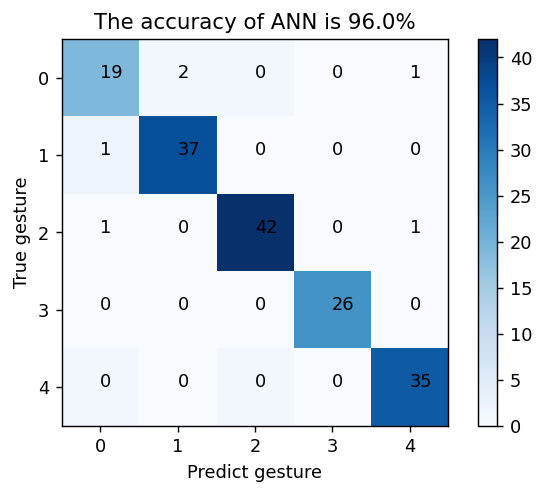

In [9]:
X, y = load_data(gesture)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3,random_state=2022)
model_ann = ANN(1,49,11)
model_ann.fit(X_train,y_train,epochs=10, batch_size=4)

y_test_ann_pred = model_ann.predict(X_test)
y_test, y_test_ann_pred = count_label(y_test, y_test_ann_pred)
plot_matrix(y_test,y_test_ann_pred,'ANN')

Epoch 1/10
96/96 [==============================] - 0s 1ms/step - loss: 1.4778 - accuracy: 0.4804
Epoch 2/10
96/96 [==============================] - 0s 1ms/step - loss: 0.9980 - accuracy: 0.5953
Epoch 3/10
96/96 [==============================] - 0s 1ms/step - loss: 0.6673 - accuracy: 0.7572
Epoch 4/10
96/96 [==============================] - 0s 1ms/step - loss: 0.4837 - accuracy: 0.8642
Epoch 5/10
96/96 [==============================] - 0s 1ms/step - loss: 0.3384 - accuracy: 0.9086
Epoch 6/10
96/96 [==============================] - 0s 1ms/step - loss: 0.2337 - accuracy: 0.9452
Epoch 7/10
96/96 [==============================] - 0s 1ms/step - loss: 0.1668 - accuracy: 0.9608
Epoch 8/10
96/96 [==============================] - 0s 1ms/step - loss: 0.1223 - accuracy: 0.9739
Epoch 9/10
96/96 [==============================] - 0s 1ms/step - loss: 0.0944 - accuracy: 0.9791
Epoch 10/10
6/6 [==============================] - 0s 2ms/step


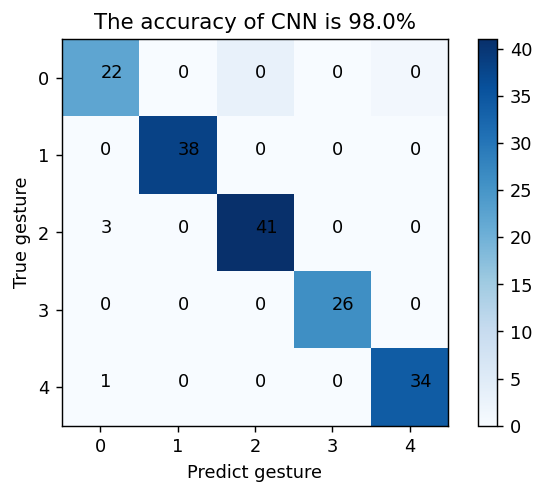

In [10]:
model_cnn = CNN(1,49,11)
model_cnn.fit(X_train,y_train,epochs=10, batch_size=4)

X, y = load_data(gesture)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3,random_state=2022)
y_test_cnn_pred = model_cnn.predict(X_test)

y_test, y_test_cnn_pred = count_label(y_test, y_test_cnn_pred)
plot_matrix(y_test,y_test_cnn_pred,'CNN')